# Discrete Response and Z Transforms

## https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cont2discrete.html

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, savefig
import numpy as np
from scipy.signal import cont2discrete, lti, dlti, dstep, dlsim, lsim, ss2tf, residue, residuez, convolve

%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 5.0]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.grid'] = True

SMALL_SIZE = 14
MEDIUM_SIZE = 24
BIGGER_SIZE = 32

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def nicegrid(ax=plt):
    ax.grid(True, which='major', color='#666666', linestyle=':')
    ax.grid(True, which='minor', color='#999999', linestyle=':', alpha=0.2)
    ax.minorticks_on()

def my_stem(t,y,ax='ax1',lab='y',params='r',size=8):
    markerline, stemline, baseline = ax.stem(t, y, label=lab,linefmt=params+'-',markerfmt=params+'o',basefmt=params+'.')
    plt.setp(stemline, linewidth = .25)
    plt.setp(markerline, markersize = size)
    markerline.set_markerfacecolor(params)

import warnings
warnings.filterwarnings("ignore")

In [2]:
%store -r which_example
try:
    which_example
except NameError:
    which_example = 0 # default to first example
    
if which_example == 'First': # ok sample rate
    print('Doing first example')
    # discretize using a time step of dt
    dt = 0.5
    Tstep = dt-1e-6 # step start time
    Tf = 6 # how long a step
else: # bad choice
    print('Doing second example')
    # discretize using a time step of dt
    dt = 2
    Tstep = dt-1e-6 # step start time
    Tf = 12 # how long a step

Doing second example


In [3]:
T=np.linspace(0, Tstep+Tf, 1000) # finely discretized cts time
T_d = np.arange(0,max(T)+1,dt) # coarse discrete time

In [4]:
# cts system
A = np.array([[0, 1],[-10., -.9]])
B = np.array([[0],[10.]])
C = np.array([[1., 0]])
D = np.array([[0.]])
l_system = lti(A, B, C, D)

In [5]:
#form discrete equivalent
d_system = l_system.to_discrete(dt,'zoh')

In [6]:
# input
u = np.zeros(len(T))
u = [1 if g >= Tstep else 0 for g in T]

u_d = np.zeros(len(T_d))
u_d = [1 if g >= Tstep else 0 for g in T_d]

In [7]:
# simulate
t, y, x = lsim(l_system,u,T)
t_d, y_d, x_d = dlsim(d_system,u_d)

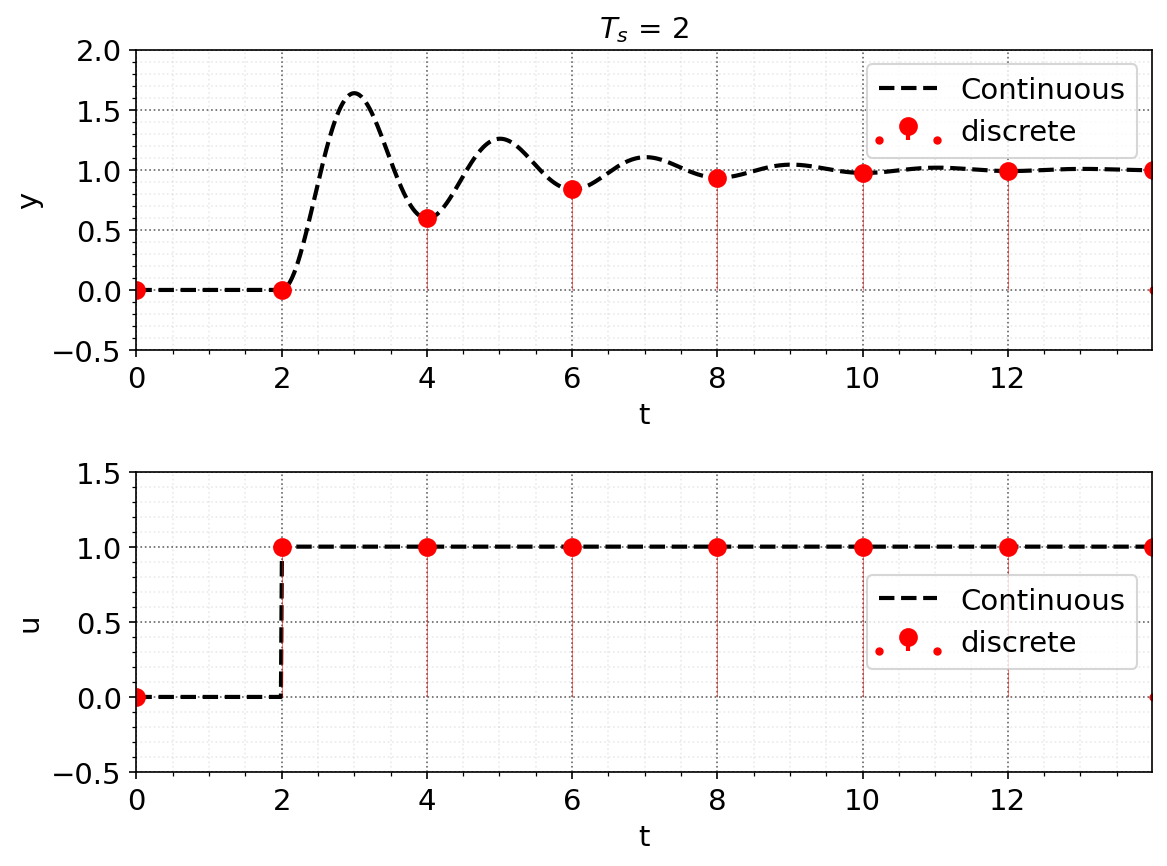

In [8]:
# plot
fig, (ax1,ax2) = plt.subplots(2,figsize=(8, 6),dpi=150)
ax1.plot(t, y, 'k--', label='Continuous', linewidth=2)
my_stem(t_d,y_d,ax1,lab='discrete')

ax1.axis([t[0], t[-2], -.5, int(max(y)+1)])
ax1.legend(loc='best')
ax1.set_ylabel('y')
ax1.set_xlabel('t')
ax1.set_title(f'$T_s$ = '+str(dt))
nicegrid(ax1)

ax2.plot(t, u, 'k--', label='Continuous', linewidth=2)
my_stem(t_d,u_d,ax2,lab='discrete')
ax2.axis([t[0], t[-2], -.5, 1.5])
ax2.legend(loc='best')
ax2.set_ylabel('u')
ax2.set_xlabel('t')
fig.tight_layout()
nicegrid(ax2)
plt.show()

## Predict using inverse Z transform

In [9]:
# Form discrete plant model
Gz = ss2tf(d_system.A, d_system.B, d_system.C, d_system.D)

In [10]:
# tranform of the step ftn
Hz = dlti([1, 0],[1, -1],dt=dt)

In [11]:
# product of the step and plant
GH = dlti(convolve(Gz[0][0],Hz.num),convolve(Gz[1],Hz.den),dt=dt)
# divide GH by z so that we can do a PFE
GHdz = dlti(GH.num[0:2],GH.den,dt=dt)
# the z in the original numerator is implicitly added back in during the inv Z TF

In [12]:
# PFE
[r,p,k]=residue(GHdz.num, GHdz.den);

In [13]:
# find the num/den associated with the 2 complex poles
num_sec = convolve([1, 0],[r[0]*1+r[1]*1, -r[0]*p[1]-r[1]*p[0]]);
den_sec = convolve([1, -p[0]],[1, -p[1]]);

$$ a^n \sin(\Omega_0n)u[n] \Leftrightarrow \frac{az\sin(\Omega_0)}{z^2-2za\cos(\Omega_0)+a^2} $$

$$ a^n \cos(\Omega_0n)u[n] \Leftrightarrow \frac{z(z-a\cos(\Omega_0))}{z^2-2za\cos(\Omega_0)+a^2} $$

In [14]:
# compute the a and \Omega0 values given the num/den of GHdz
a = np.sqrt(den_sec[2])
COmega0 = den_sec[1]/(-2*a)
SOmega0 = np.sqrt(1-COmega0**2)
Omega0 = np.arccos(COmega0);

# find coeffs of the cos {gain} and sin {gain*alpha} terms in the inv Z TF
gain = num_sec[0];
num_sec_norm = num_sec/gain;
alpha = (num_sec_norm[1]+a*COmega0)/a/SOmega0 # coeff of the sine term

# gain*(a^k cos(Omega_0 k) + alpha a^k sin(Omega_0 k))

In [15]:
# discrete step ftn
def discrete_u(tt):
    x = [1 if x >= 0 else 0 for x in tt]
    return x

In [16]:
kstart = Tstep//dt+1 
kk = np.arange(0,len(t_d)-1,1)
y_pred = r[2]+gain*(a**(kk-kstart))*(np.cos(Omega0*(kk-kstart))+alpha*np.sin(Omega0*(kk-kstart)))
y_pred = y_pred*discrete_u(kk-kstart);
t_pred = kk*dt;

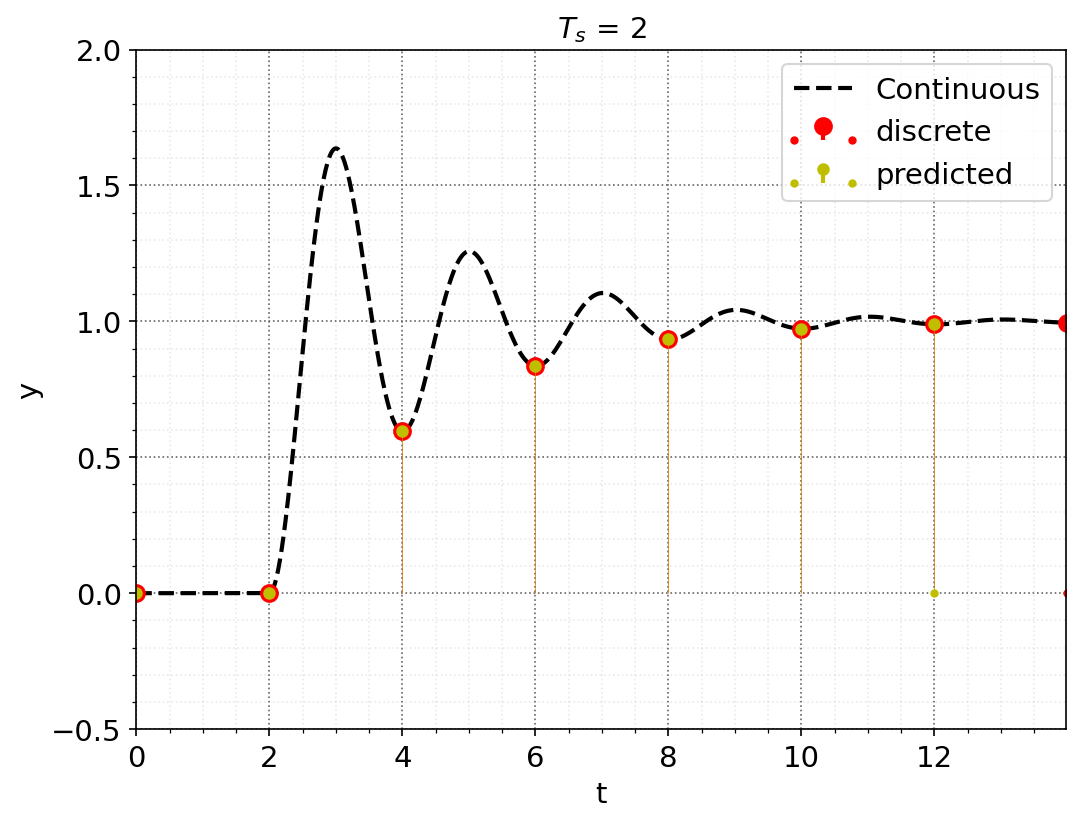

In [17]:
# plot
fig, ax1 = plt.subplots(1,figsize=(8, 6),dpi=150)
ax1.plot(t, y, 'k--', label='Continuous', linewidth=2)
my_stem(t_d,abs(y_d),ax1,lab='discrete')
my_stem(t_pred,abs(y_pred),ax1,lab='predicted',params='y',size=5)
ax1.set_ylabel('y')
ax1.set_xlabel('t')
ax1.set_title(f'$T_s$ = '+str(dt))
ax1.axis([t[0], t[-2], -.5, int(max(y)+1)])
ax1.legend(loc='best')
nicegrid()
plt.show()

In [18]:
np.linalg.eig(d_system.A)[0]

array([0.40646219+0.00934768j, 0.40646219-0.00934768j])